In [14]:
import json
with open("config.json") as json_file:
    parameter = json.load(json_file)
print "Number of threads", parameter["NUM_THREADS"]

Number of threads 48


# Load dataset

In [16]:
import numpy as np
import pickle

with open(parameter["SAVE_DIR"]+"TCC_matrix.dat", 'rb') as f:
    T=pickle.load(f)
with open(parameter["SAVE_DIR"]+"pwise_dist_L1.dat", 'rb') as f:
    D_l1=pickle.load(f)
with open(parameter["SAVE_DIR"]+"nonzero_ec.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)
T_norm = T/np.array(T.sum(axis=0),dtype='double')
T_normT = T_norm.transpose()    
NUM_OF_CELLS=np.shape(T)[1]
print "NUM_OF_CELLS =", NUM_OF_CELLS
print "eq_classes =", np.shape(T)[0]

NUM_OF_CELLS = 1298
eq_classes = 15679


In [17]:
EC_dict = {}
for i in range(np.shape(ec)[0]):
    EC_dict[i] = [int(x) for x in ec[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=list(union)
NUM_OF_TX_inTCC = len(union)
print "NUM_OF_TX_inTCC =", NUM_OF_TX_inTCC

NUM_OF_TX_inTCC = 35022


### Inspect

In [18]:
#sort eq. classes based on size
size_of_ec = [len(EC_dict[i]) for i in nonzero_ec]
ec_idx = [i[0] for i in sorted(enumerate(size_of_ec), key=lambda x:x[1])]
index_ec = np.array(ec_idx)

ec_sort_map={}
nonzero_ec_srt=[]; #init
for i in range(len(nonzero_ec)):
    nonzero_ec_srt+=[nonzero_ec[index_ec[i]]]
    ec_sort_map[nonzero_ec[index_ec[i]]] = i
nonzero_ec_srt = np.array(nonzero_ec_srt)

ec_size_sort=np.array(size_of_ec)[index_ec]
sumi = T.sum(axis=1)
sumi_sorted=sumi[index_ec]
total_num_of_reads = sum(sumi_sorted)
total_num_of_reads_cell = T.sum(axis=0)

print "Total number of reads =", total_num_of_reads

Total number of reads = 59756


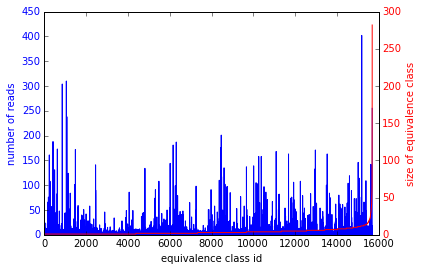

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot(sumi_sorted, 'b-')
ax1.set_xlabel('equivalence class id')
ax1.set_ylabel('number of reads', color='b')
# ax1.set_xlim([0,620000])
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()

ax2.plot(ec_size_sort, 'r')
ax2.set_ylabel('size of equivalence class', color='r')
# ax2.set_xlim([0,620000])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

# Clustering

In [20]:
from sklearn import cluster,manifold
import matplotlib.pyplot as plt
%matplotlib inline

def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',
                                     preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

def spectral(k,D):
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=2000, verbose=1);
    X_tsne = tsne.fit_transform(D);
    return X_tsne

In [21]:
X_tsne=tSNE_pairwise(D_l1)

[t-SNE] Computed conditional probabilities for sample 1000 / 1298
[t-SNE] Computed conditional probabilities for sample 1298 / 1298
[t-SNE] Mean sigma: 0.152141
[t-SNE] Error after 65 iterations with early exaggeration: 20.968013
[t-SNE] Error after 135 iterations: 2.431350


In [22]:
# Plot function with (nonrandom) colors corresponding to labels (star a specific label)
def stain_plot(X,labels,stain,title,nc=2):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), 
             int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=146,edgecolors='black',
                        lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolors='gray',
                        lw = 0.5,label=label)        
        i+=1   
    plt.title(title)
    plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=nc)
#     plt.xlim([-20,20])
#     plt.ylim([-20,20])
    plt.axis('off')

In [23]:
labels_2 = spectral(2,D_l1.max()-D_l1)

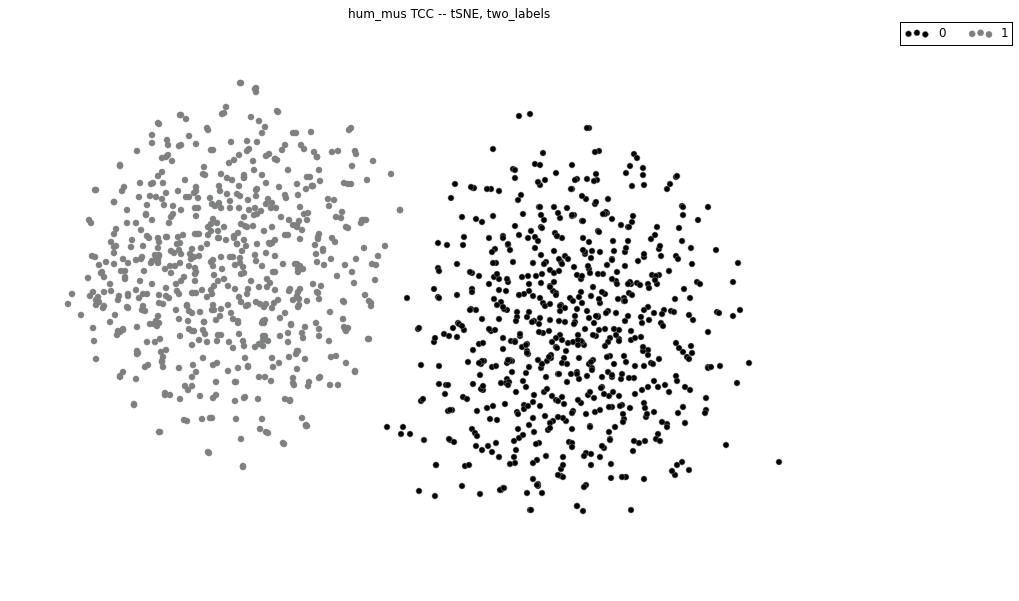

In [43]:
stain_plot(X_tsne,labels_2,[],"hum_mus TCC -- tSNE, two_labels")

In [ ]:
pref = -np.median(D_l1)*np.ones(NUM_OF_CELLS)
labels_aff=AffinityProp(-D_l1,pref,0.5)
np.unique(labels_aff)

In [ ]:
stain_plot(X_tsne,labels_aff,[],"hum_mus TCC -- tSNE, AP_labels")

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(T_normT)

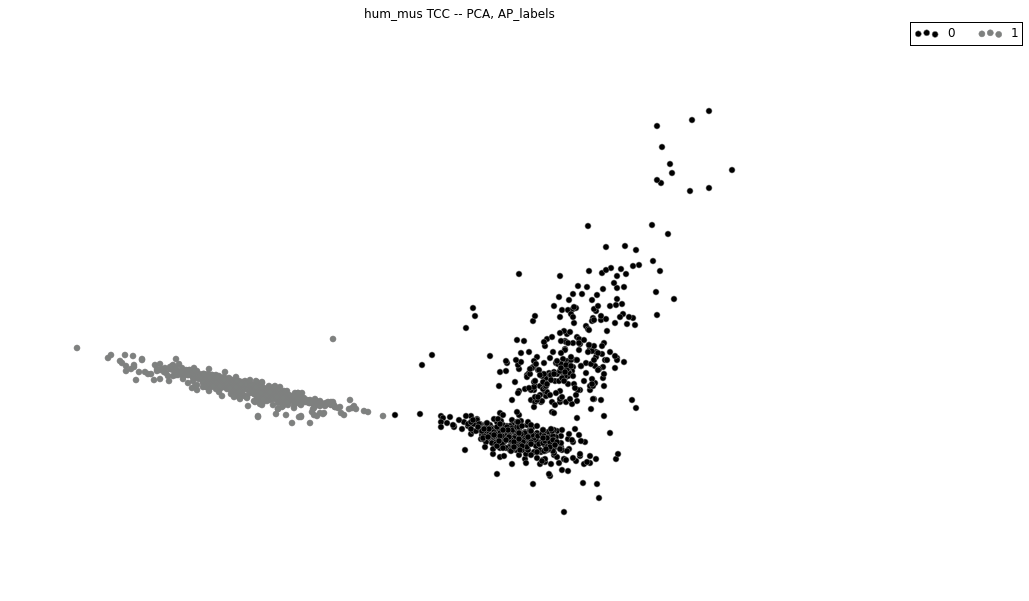

In [42]:
stain_plot(X_pca,labels_2,[],"hum_mus TCC -- PCA, AP_labels")

### --------------